# Karras pre-conditioning

In [ ]:
import os
# os.environ['CUDA_VISIBLE_DEVICES']='1'

In [ ]:
import timm, torch, random, datasets, math, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

In [ ]:
from fastprogress import progress_bar
from diffusers import UNet2DModel, DDIMPipeline, DDPMPipeline, DDIMScheduler, DDPMScheduler

In [ ]:
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
n_steps = 1000
bs = 512
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
sig_data = 0.66

In [ ]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

def scalings(sig):
    totvar = sig**2+sig_data**2
    # c_skip,c_out,c_in
    return sig_data**2/totvar,sig*sig_data/totvar.sqrt(),1/totvar.sqrt()

def noisify(x0):
    device = x0.device
    sig = (torch.randn([len(x0)])*1.2-1.2).exp().to(x0).reshape(-1,1,1,1)
    noise = torch.randn_like(x0, device=device)
    c_skip,c_out,c_in = scalings(sig)
    noised_input = x0 + noise*sig
    target = (x0-c_skip*noised_input)/c_out
    return (noised_input*c_in,sig.squeeze()),target

def collate_ddpm(b): return noisify(default_collate(b)[xl])
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=0)

In [ ]:
tds = dsd.with_transform(transformi)
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

## Train

Based on Diffusers

In [ ]:
def unet_conv(ni, nf, ks=3, stride=1, act=nn.ReLU, norm=None, bias=True):
    layers = []
    if norm: layers.append(norm(ni))
    if act : layers.append(act())
    layers.append(nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias))
    return nn.Sequential(*layers)

In [ ]:
class UnetResBlock(nn.Module):
    def __init__(self, ni, nf=None, ks=3, act=nn.SiLU, norm=nn.BatchNorm2d):
        super().__init__()
        if nf is None: nf = ni
        self.convs = nn.Sequential(unet_conv(ni, nf, ks, act=act, norm=norm),
                                   unet_conv(nf, nf, ks, act=act, norm=norm))
        self.idconv = fc.noop if ni==nf else nn.Conv2d(ni, nf, 1)

    def forward(self, x): return self.convs(x) + self.idconv(x)

In [ ]:
class A:
    def __call__(self):
        super().__call__()
        print('a')

class B:
    def __call__(self): print('b')

class C(A,B): pass

In [ ]:
C()()

b
a


In [ ]:
class SaveModule:
    def forward(self, x, *args, **kwargs):
        self.saved = super().forward(x, *args, **kwargs)
        return self.saved

class SavedResBlock(SaveModule, UnetResBlock): pass
class SavedConv(SaveModule, nn.Conv2d): pass

In [ ]:
def down_block(ni, nf, add_down=True, num_layers=1):
    res = nn.Sequential(*[SavedResBlock(ni=ni if i==0 else nf, nf=nf)
                         for i in range(num_layers)])
    if add_down: res.append(SavedConv(nf, nf, 3, stride=2, padding=1))
    return res

In [ ]:
def upsample(nf): return nn.Sequential(nn.Upsample(scale_factor=2.), nn.Conv2d(nf, nf, 3, padding=1))

In [ ]:
class UpBlock(nn.Module):
    def __init__(self, ni, prev_nf, nf, add_up=True, num_layers=2):
        super().__init__()
        self.resnets = nn.ModuleList()
        for i in range(num_layers):
            nskip = ni if (i==num_layers-1) else nf
            resnet_ni = prev_nf if i==0 else nf
            self.resnets.append(UnetResBlock(resnet_ni+nskip, nf))
        self.up = upsample(nf) if add_up else None

    def forward(self, x, ups):
        for resnet in self.resnets: x = resnet(torch.cat([x, ups.pop()], dim=1))
        if self.up is not None: x = self.up(x)
        return x

In [ ]:
class UNet2DModel(nn.Module):
    def __init__( self, in_channels=3, out_channels=3, nfs=(224,448,672,896), num_layers=1):
        super().__init__()
        self.conv_in = nn.Conv2d(in_channels, nfs[0], kernel_size=3, padding=1)
        nf = nfs[0]
        self.downs = nn.Sequential()
        for i in range(len(nfs)):
            ni = nf
            nf = nfs[i]
            self.downs.append(down_block(ni, nf, add_down=i!=len(nfs)-1, num_layers=num_layers))
        self.mid_block = UnetResBlock(nfs[-1])

        rev_nfs = list(reversed(nfs))
        nf = rev_nfs[0]
        self.ups = nn.ModuleList()
        for i in range(len(nfs)):
            prev_nf = nf
            nf = rev_nfs[i]
            ni = rev_nfs[min(i+1, len(nfs)-1)]
            self.ups.append(UpBlock(ni, prev_nf, nf, add_up=i!=len(nfs)-1, num_layers=num_layers+1))
        self.conv_out = unet_conv(nfs[0], out_channels, act=nn.SiLU, norm=nn.BatchNorm2d)

    def forward(self, inp):
        x = self.conv_in(inp[0])
        saved = [x]
        x = self.downs(x)
        saved += [p.saved for o in self.downs for p in o]
        x = self.mid_block(x)
        for block in self.ups: x = block(x, saved)
        return self.conv_out(x)

In [ ]:
model = UNet2DModel(in_channels=1, out_channels=1, nfs=(32,64,128,256), num_layers=2)

In [ ]:
lr = 1e-3
epochs = 4
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.547,0,train
0.319,0,eval
0.225,1,train
0.385,1,eval
0.194,2,train
0.187,2,eval
0.184,3,train
0.182,3,eval


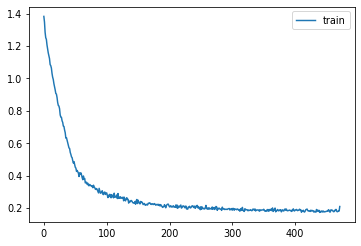

In [ ]:
learn.fit(epochs)

In [ ]:
lr = 3e-3
epochs = 25
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.496,0,train
0.331,0,eval
0.245,1,train
0.238,1,eval
0.209,2,train
0.230,2,eval
0.195,3,train
0.208,3,eval
0.185,4,train
0.225,4,eval


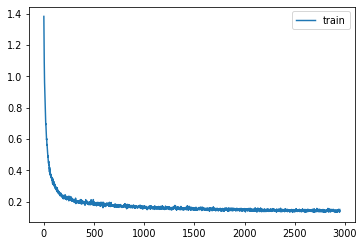

In [ ]:
learn.fit(epochs)

## Timesteps

In [ ]:
emb_dim = 16
tsteps = torch.linspace(-10,10,100)
max_period= 10000

In [ ]:
math.log(10000)

9.210340371976184

In [ ]:
exponent = -math.log(max_period) * torch.linspace(0, 1, emb_dim//2, device=tsteps.device)

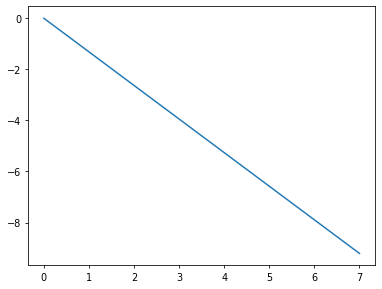

In [ ]:
plt.plot(exponent);

In [ ]:
emb = tsteps[:,None].float() * exponent.exp()[None,:]
emb.shape

torch.Size([100, 8])

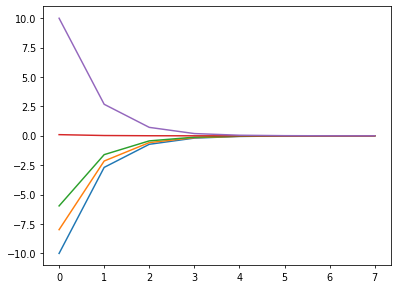

In [ ]:
plt.plot(emb[0])
plt.plot(emb[10])
plt.plot(emb[20])
plt.plot(emb[50])
plt.plot(emb[-1]);

In [ ]:
emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
emb.shape

torch.Size([100, 16])

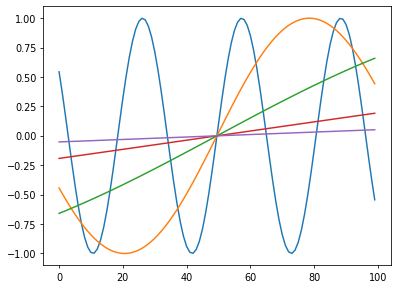

In [ ]:
plt.plot(emb[:,0])
plt.plot(emb[:,1])
plt.plot(emb[:,2])
plt.plot(emb[:,3])
plt.plot(emb[:,4]);

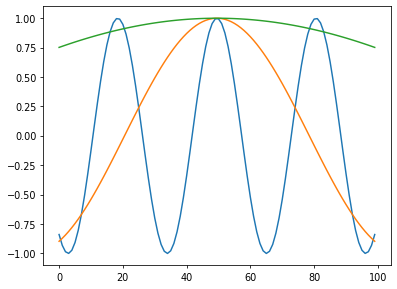

In [ ]:
plt.plot(emb[:,8])
plt.plot(emb[:,9])
plt.plot(emb[:,10]);

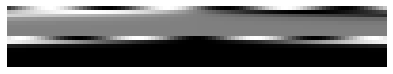

In [ ]:
show_image(emb.T, figsize=(7,7));

In [ ]:
def timestep_embedding(tsteps, emb_dim, max_period= 10000):
    exponent = -math.log(max_period) * torch.linspace(0, 1, emb_dim//2, device=tsteps.device)
    emb = tsteps[:,None].float() * exponent.exp()[None,:]
    emb = torch.cat([emb.sin(), emb.cos()], dim=-1)
    return F.pad(emb, (0,1,0,0)) if emb_dim%2==1 else emb

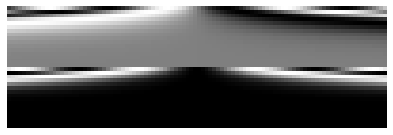

In [ ]:
show_image(timestep_embedding(tsteps, 32, max_period=1000).T, figsize=(7,7));

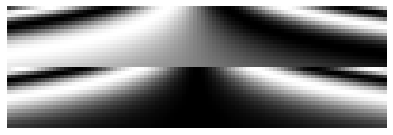

In [ ]:
show_image(timestep_embedding(tsteps, 32, max_period=10).T, figsize=(7,7));